In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

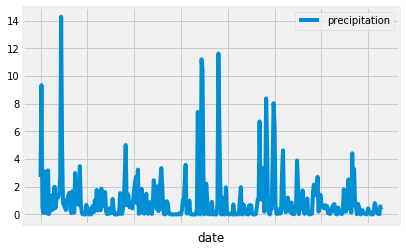

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

import datetime as dt
import pandas as pd

# get the last date and substract 1 year
last_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date_str,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
first_date = dt.date(year=last_date.year-1,month=last_date.month,day=last_date.day)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,func.sum(Measurement.prcp)).\
    filter(Measurement.date >= first_date). \
    group_by(Measurement.date).order_by(Measurement.date).all()

dates, prcps = zip(*results) # unzip

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({'date':dates, 'precipitation':prcps})
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

# Lidio comment: Note the summary statistics differ from the one shown on the figure below
# because I summed the total precipation per date

precipitation
count     366.000000
mean        0.978907
std         1.776349
min         0.000000
25%         0.052500
50%         0.405000
75%         1.087500
max        14.280000

![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_counts = session.query(Measurement.station,func.count(1)). \
    group_by(Measurement.station).order_by(func.count(1).desc()).all()

# Lidio comment: The query above counts the number of rows per station;
# however, some of these rows contain null values for precipitation.
# In order to count non-null values we can use func.count(Measurement.prcp)
# instead of func.count(1).

num_stations = len(stations_counts)
most_active_station = stations_counts[0][0]
print(f"Number of stations: {num_stations}")
print(f"Most active station is {stations_counts[0][0]} with {stations_counts[0][1]} rows")
print()
for station, count  in stations_counts:
    print(station + ': ' + str(count))


Number of stations: 9
Most active station is USC00519281 with 2772 rows

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
results = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)). \
    filter(Measurement.station == most_active_station).all()
print(results)

[(54.0, 85.0, 71.66378066378067)]


Text(0, 0.5, 'Frequency')

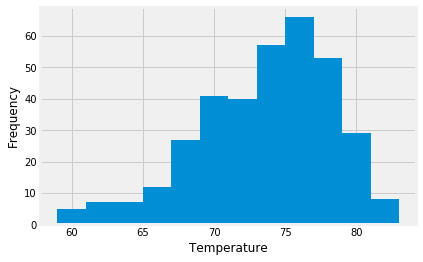

In [14]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station == most_active_station). \
    filter(Measurement.date >= first_date).all()

tobs = np.ravel(results)
plt.hist(tobs,bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

![precipitation](Images/station-histogram.png)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# my trip dates
start_date = '2017-03-10'
end_date = '2017-03-20'
mint, avgt, maxt = calc_temps(start_date,end_date)[0]
print(mint,avgt, maxt)

65.0 71.82089552238806 82.0


Text(0, 0.5, 'Temp (F)')

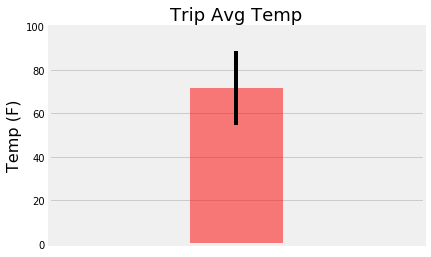

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = avgt
x = 1
yerr = maxt - mint
plt.bar(x, y, width=0.5, yerr=yerr, fc='red', alpha=0.5)
plt.xlim(0,2)
plt.ylim(0,100)
plt.xticks([])
plt.title('Trip Avg Temp', fontsize=18)
plt.ylabel('Temp (F)', fontsize=16)

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,\
    Station.longitude,Station.elevation).filter(Measurement.station==Station.station). \
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date). \
    group_by(Measurement.station). \
    order_by(func.sum(Measurement.prcp).desc()).all()

station, total_prcp, name, lat, long, elevation = zip(*results)
df2 = pd.DataFrame({ 'station': station, 'total_prcp': total_prcp, 'name': name, \
                    'lat': lat, 'long': long, 'elevation': elevation })
df2


station  total_prcp                                    name       lat  \
0  USC00513117        0.35                    KANEOHE 838.1, HI US  21.42340   
1  USC00519523        0.35      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
2  USC00519281        0.24                     WAIHEE 837.5, HI US  21.45167   
3  USC00514830        0.19  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
4  USC00517948        0.06                       PEARL CITY, HI US  21.39340   
5  USC00516128        0.00            MANOA LYON ARBO 785.2, HI US  21.33310   
6  USC00519397        0.00                    WAIKIKI 717.2, HI US  21.27160   

        long  elevation  
0 -157.80150       14.6  
1 -157.71139       19.5  
2 -157.84889       32.9  
3 -157.83740        7.0  
4 -157.97510       11.9  
5 -157.80250      152.4  
6 -157.81680        3.0

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
